In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB7, ResNet50
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
csv_path = '/kaggle/input/flood-dataset/devset_images_gt.csv'
df = pd.read_csv(csv_path)

In [3]:
# Read files containing images and filter valid files (not starting with '._')
image_folder_path = '/kaggle/input/flood-dataset/devset_images/devset_images'
image_files = [file for file in os.listdir(image_folder_path) if not file.startswith('._')]

# Find images with corresponding labels in both files
selected_image_files = []
selected_labels = []

for image_file in image_files:
    image_id = int(image_file.split('.')[0])  # Extract ID from photo filename
    label = df[df['id'] == image_id]['label'].values
    if len(label) > 0:
        selected_image_files.append(image_file)
        selected_labels.append(label[0])

# Build dataset
X = []
y = []

for image_file, label in zip(selected_image_files, selected_labels):
    image_path = os.path.join(image_folder_path, image_file)
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = np.array(image)
    X.append(image)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Define a custom learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.0001
    if epoch < 20:
        return initial_lr
    elif epoch < 35:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

In [6]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Randomly zoom in by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in missing pixels with the nearest available pixel value
)

# Define batch size and number of epochs
batch_size = 16

# Create a data generator for training data with data augmentation
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)

# Use the original X_test and y_test for validation
valid_generator = datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)


In [7]:
# Load the pre-trained EfficientNetB7 model
base_model_efficientnet = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Unfreeze the top layers of EfficientNet
for layer in base_model_efficientnet.layers[-20:]:
    layer.trainable = True

# Create the first model (EfficientNet)
input_efficientnet = Input(shape=(224, 224, 3))
x_efficientnet = base_model_efficientnet(input_efficientnet)
x_efficientnet = GlobalAveragePooling2D()(x_efficientnet)
x_efficientnet = BatchNormalization()(x_efficientnet)
x_efficientnet = Dropout(0.5)(x_efficientnet)
x_efficientnet = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x_efficientnet)
x_efficientnet = BatchNormalization()(x_efficientnet)
x_efficientnet = Dropout(0.5)(x_efficientnet)
output_efficientnet = Dense(1, activation='sigmoid')(x_efficientnet)
model_efficientnet = Model(inputs=input_efficientnet, outputs=output_efficientnet)

# Load the pre-trained ResNet50 model
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Unfreeze the top layers of ResNet
for layer in base_model_resnet.layers[-20:]:
    layer.trainable = True

# Create the second model (ResNet)
input_resnet = Input(shape=(224, 224, 3))
x_resnet = base_model_resnet(input_resnet)
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = BatchNormalization()(x_resnet)
x_resnet = Dropout(0.5)(x_resnet)
x_resnet = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x_resnet)
x_resnet = BatchNormalization()(x_resnet)
x_resnet = Dropout(0.5)(x_resnet)
output_resnet = Dense(1, activation='sigmoid')(x_resnet)
model_resnet = Model(inputs=input_resnet, outputs=output_resnet)

# Combine the two models into an ensemble model
ensemble_input = Input(shape=(224, 224, 3))
output_efficientnet = model_efficientnet(ensemble_input)
output_resnet = model_resnet(ensemble_input)
ensemble_output = tf.keras.layers.Average()([output_efficientnet, output_resnet])  # Average the predictions
ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_output)

# Define optimizer with a small learning rate for fine-tuning
optimizer = RMSprop(learning_rate=0.00001)

# Compile the ensemble model
ensemble_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1)            66735512    ['input_5[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            25699201    ['input_5[0][0]']                
                                                                                                  
 average (Average)              (None, 1)            0           ['model[0][0]',            

In [8]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping class indices to their respective weights
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-7)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)

# Fine-tune the model
history = ensemble_model.fit(
    train_datagen,
    epochs=50,  # Adjust the number of epochs
    validation_data=(X_test, y_test),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights_dict  # Use class weights if your dataset is imbalanced
)

# Load the best weights
ensemble_model.load_weights('best_model.h5')

Epoch 1/50


2023-10-05 06:36:01.759272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


297/297 [==============================] - 370s 740ms/step - loss: 3.1513 - accuracy: 0.8049 - val_loss: 2.8623 - val_accuracy: 0.8655 - lr: 1.0000e-04
Epoch 2/50
297/297 [==============================] - 212s 714ms/step - loss: 2.8257 - accuracy: 0.8660 - val_loss: 2.8472 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/50
297/297 [==============================] - 211s 709ms/step - loss: 2.5579 - accuracy: 0.8786 - val_loss: 2.3789 - val_accuracy: 0.8712 - lr: 1.0000e-04
Epoch 4/50
297/297 [==============================] - 212s 713ms/step - loss: 2.2846 - accuracy: 0.8904 - val_loss: 2.1340 - val_accuracy: 0.9110 - lr: 1.0000e-04
Epoch 5/50
297/297 [==============================] - 211s 710ms/step - loss: 2.0450 - accuracy: 0.9015 - val_loss: 1.9588 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 6/50
297/297 [==============================] - 211s 710ms/step - loss: 1.7883 - accuracy: 0.9120 - val_loss: 1.7164 - val_accuracy: 0.9223 - lr: 1.0000e-04
Epoch 7/50
297/297 [=============

In [9]:
# Evaluate the ensemble model on the test data
test_loss, test_accuracy = ensemble_model.evaluate(X_test, y_test)
print("Test Accuracy for Ensemble Model:", test_accuracy)

17/17 [==============================] - 4s 251ms/step - loss: 0.3869 - accuracy: 0.9356
Test Accuracy for Ensemble Model: 0.935606062412262


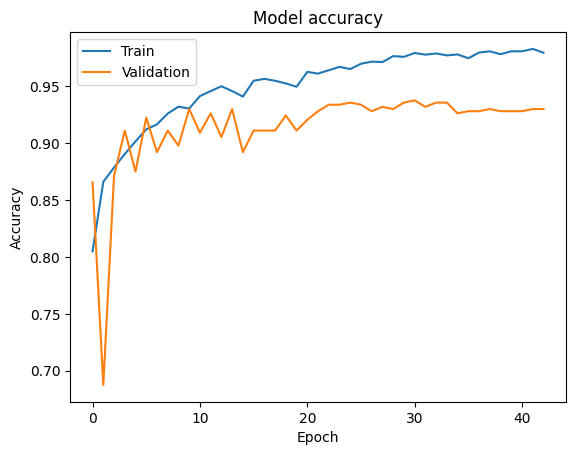

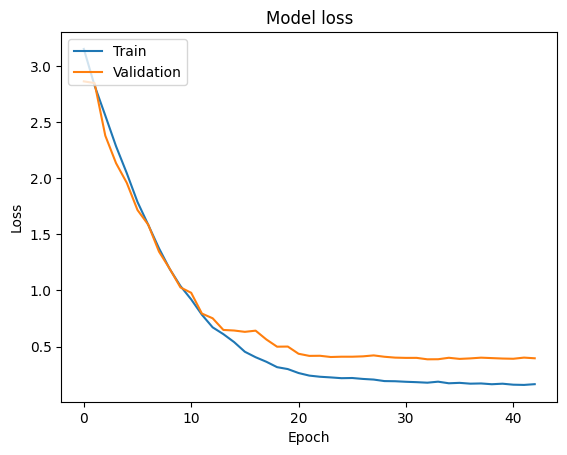

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
# Load and preprocess the test images
test_image_folder_path = '/kaggle/input/flood-dataset/testset_images/testset_images'
test_image_files = [file for file in os.listdir(test_image_folder_path) if not file.startswith('._')]

X_test = []

for image_file in test_image_files:
    image_id_str = image_file.split('.')[0]
    image_id = int(image_id_str)
    image_path = os.path.join(test_image_folder_path, image_file)
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = np.array(image)
    X_test.append(image)

X_test = np.array(X_test)

# Make predictions on the test data
test_predictions = ensemble_model.predict(X_test)

# Create a DataFrame for the test predictions
test_df = pd.DataFrame({'id': [int(file.split('.')[0]) for file in test_image_files],
                        'label': (test_predictions > 0.5).astype(int).flatten()})

# Export the test predictions to a CSV file
test_predictions_csv_path = '/kaggle/working/test_predictions.csv'
test_df.to_csv(test_predictions_csv_path, index=False)

print(f'Test predictions saved to {test_predictions_csv_path}')

42/42 [==============================] - 18s 270ms/step
Test predictions saved to /kaggle/working/test_predictions.csv
